This notebook stores all of the plots I want to use in my REU paper

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import richardsplot
from astropy.cosmology import FlatLambdaCDM
import scipy.stats as spstats

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on data at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

In [4]:
df = pd.read_csv("RQQfigs.csv")

S6 = df[["Flux"]].values.flatten()
det = df[["Detection"]].values.flatten()==1
z = df[["z"]].values.flatten()
vlba = df[["VLBA"]].values.flatten()==1
#L6 = L_6(z, S6, -0.7)
L6 = radluminosity(6., 6., S6, -0.7, z)

df["logL6GHz [W/Hz]"] = L6
df.to_csv("RQQfigs.csv", index=False)


S6_kell = df[["S(6)_t"]].values.flatten()
L6_kell = radluminosity(6., 6., S6_kell, -0.7, z)

Text(0.5, 0, '$logL_{6GHz} / [W Hz^{-1}]$')

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


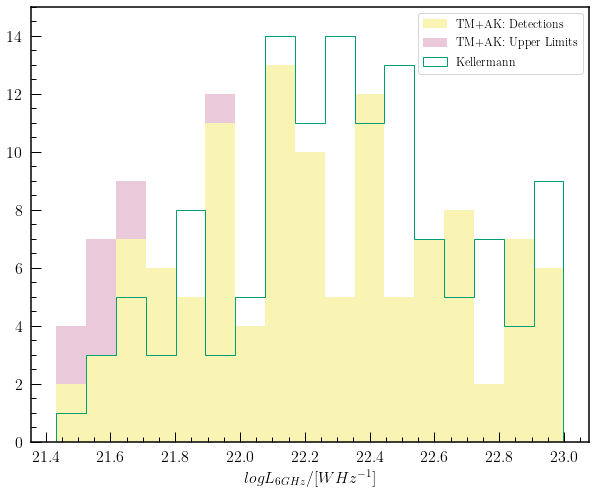

In [5]:
fig = plt.figure(figsize=(10,8))
bins3 = np.linspace(min(L6), max(L6_kell), 18)

plt.hist([L6[det], L6[~det]], histtype="barstacked", color=["#f0e442", "#cc79a7"], 
         alpha=0.4, bins=bins3, label=["TM+AK: Detections", "TM+AK: Upper Limits"])
plt.hist(L6_kell, histtype="step", color="#009e73", label="Kellermann",
          bins=bins3)

plt.ylim(0,15)
plt.legend(loc="best")
plt.xlabel("$logL_{6GHz} / [W Hz^{-1}]$")
#plt.grid(True)

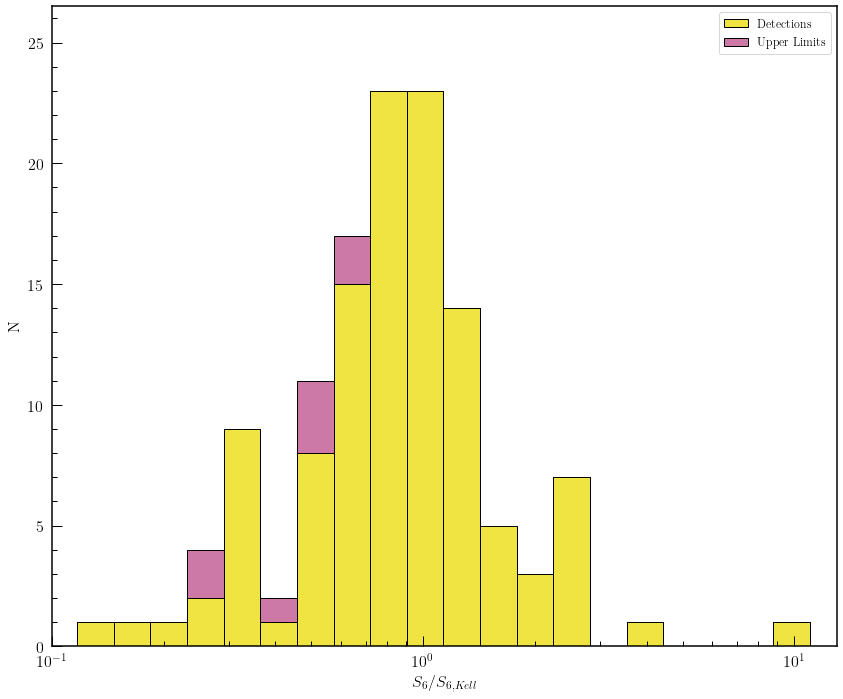

Median ratio: 0.85
Mean ratio  : 1.04
Std ratio   : 1.08


In [6]:
flux_ratio = S6/S6_kell
bins4 = np.logspace(np.log10(min(flux_ratio)), np.log10(max(flux_ratio)), 25)

fig = plt.figure(figsize=(12,10))

plt.hist([flux_ratio[det], flux_ratio[~det]], histtype="barstacked", color=["#f0e442", "#cc79a7"],
          edgecolor="k", bins=bins4, label=["Detections", "Upper Limits"])


#fit lognormal to the distribution
ratio_mu, ratio_loc, ratio_std = spstats.lognorm.fit(data=flux_ratio)
ratio_pdf = spstats.lognorm.pdf(x=bins4, s=ratio_std, scale=ratio_mu)
#plt.plot(bins4, ratio_pdf, '--g')

plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("$S_6/S_{6,Kell}$")
plt.ylabel("N")
plt.xlim(1e-1, 1.3e1)
plt.ylim(0,26.5)
plt.tight_layout()
#plt.savefig("peakfluxratio.pdf")
plt.show()

print("Median ratio: %.2f" % (np.median(flux_ratio)))
print("Mean ratio  : %.2f" % (np.mean(flux_ratio)))
print("Std ratio   : %.2f" % (np.std(flux_ratio)))



I'm not currently convinced by those three sources far to the right.  

I should do more imaging for sources that appear very variable in this plot, but Amy and I should also go through all images and at least assert which ones are point sources.  
    * 1034+6053 (SB1) - has strong imaging errors that need fixing
    * 1155+5021 (SB1) - may have many noise peaks and should be re-evaluated
    * 0952+5201 (SB3) - actually looks like a point source
    * 1206+2814 (SB1) - is either very interesting&confusing, or not real at all
    * 1000+1047 (SB1) - is a v. bright source and should be re-imaged; check 'lobe'
    * 0822+4553 (SB2) - maybe could use MTMFS

That would help a lot with interpreting the above plot because then we could truncate the additional flux ``imfit`` measured in calculating integrated flux, shifting the plot leftward.

---

On 8/4/2020, I collected data from Barvainis et al. (2005) and now I want to see how their claimed RQQs compare with ours.  Their parent sample selection criteria is the following:

* Select all quasars from the Palomar-Green and Large Bright Quasar Survey with $S_{\nu}>0.3mJy$
    * 10? observations - longest baseline gave angular scales $\sim1.3''$ x $1''$


* Remove lobe-dominated sources [check the angular scales - lobed sources in these sources may in fact be massive and there were probably many that we'd consider "lobe-dominated" with better resolution]


* As there was a dearth of intermediate-redshift sources, they also "arbitrarily select" 7 of the $\sim$30 sources in Veron-Cetty *that were detected in NVSS*


* Amounts to choosing 11 RQQs, 11 RIQs, 11 RLQs


* Used 3C48 as flux density calibrator, although they mention that this was accounted for by using a nearby phase calibrator...


* Variability occurs on timescales of ~0.2-0.5yr in RQQs, while our observations are spaced ~8yr apart

In [7]:
df3 = pd.read_csv("BarvainisRQQs.csv")

Bnames = df3[["Name"]].values.flatten()
alpha_bar = df3[["alpha"]].values.flatten()      #spectral indices measured in Barvainis+05
z_bar = df3[["z"]].values.flatten()              #redshifts range from 0.025 to 3.3
#var = df3[["f_var (%)"]].values.flatten() > 1    #mask RQQs that show variability
S_bar = df3[["S_8.4(t) [uJy]"]].values.flatten() #mean 8.4GHz flux measured 
L_bar = radluminosity(6., 8.4, S_bar, alpha_bar, z_bar)

df3["L6GHz [W/Hz; no evolution]"] = L_bar
df3["L6GHz [W/Hz; evolution]"] = np.log10((10**L_bar) * ((1+0.25)/(1+z_bar))**3)
#df3.to_csv("BarvainisRQQs.csv", index=False)

df3

,Name,z,S_8.4(t) [uJy],alpha,L6GHz [W/Hz; no evolution],L6GHz [W/Hz; evolution]
0,V0000-0229,1.070,800,-0.70,24.701365,24.044184
1,P0003+199,0.025,2300,-0.59,21.597396,21.855954
2,L0004+0224,0.300,1100,-0.59,23.541077,23.489977
3,P0049+171,0.064,700,0.46,21.733473,21.943378
4,P0052+251,0.155,700,0.48,22.497913,22.600897
5,P0157+001,0.164,4600,-0.87,23.650742,23.743613
6,L0302-0019,3.281,400,0.19,24.804575,23.200669
7,P2112+059,0.466,500,-0.52,23.604480,23.396808
8,P2130+099,0.061,1500,-0.77,22.234081,22.447664
9,L2231-0015,3.015,500,0.65,24.501564,22.981237


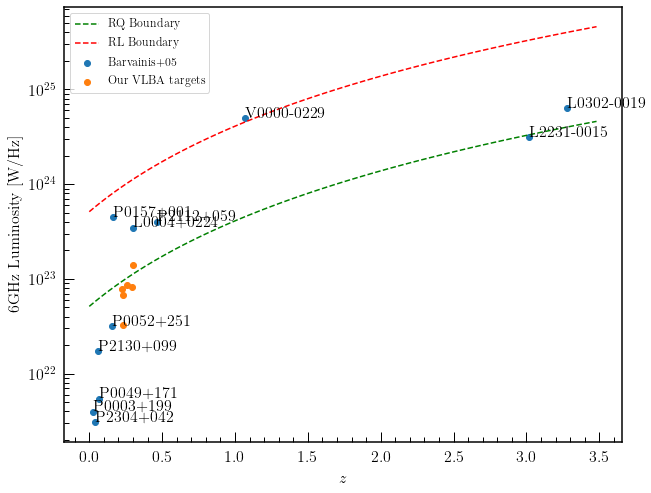

In [8]:
fig = plt.figure(figsize=(10,8))

zplot = np.linspace(0, max(z_bar)+0.2, 100)

#We define RQ to be L_6GHz < 10^23 W/Hz - compute across z

#Assume RLF evolves like (1+z)^3 - first compute at z=0 and can plot the rest
L_z0 = 10**23 / ((1+0.25)**3)
L_z01 = 10**24 / ((1+0.25)**3)
radio_quiet = L_z0*((1+zplot)**3)
radio_loud = L_z01*((1+zplot)**3)

plt.scatter(z_bar, 10**L_bar, label="Barvainis+05")
plt.scatter(z[vlba], 10**L6[vlba], label="Our VLBA targets")
plt.plot(zplot, radio_quiet, '--g', label="RQ Boundary")
plt.plot(zplot, radio_loud, '--r', label="RL Boundary")

for name,redshift,L in zip(Bnames,z_bar,L_bar):                                       
    plt.annotate('%s' % name, xy=(redshift, 10**L), textcoords='data')

#plt.xscale("log")
plt.yscale("log")
plt.ylabel("6GHz Luminosity [W/Hz]")
plt.xlabel("$z$")
plt.legend(loc="best")

Dashed green line represents the boundary between radio-quiet and radio-intermediate QSOs in a given redshift range, assuming QSOs evolve like $(1+z)^3$


Hmm, it looks like we can definitely learn a few things from this sample then... While >1/2 isn't RQ by our definition, 5 targets appear firmly RQ, and 3/5 of those RQQs appear to show some variability (values above).


Regardless of their sample, we can use our findings to back up their claims, as our time scales are much longer and we're much better-equipped to answer this question with our sample.  Something to check though: why is all their variability in the positive direction??  We seem to detect variability both ways, which is really what we expect




#### Let's further investigate variability in our sample:

[Of course the earlier ratio histogram is an indicator... (mixed in with some resolution effects)]


Also want:

* Some kind of plot showing how "resolving out" varies with C-config flux density

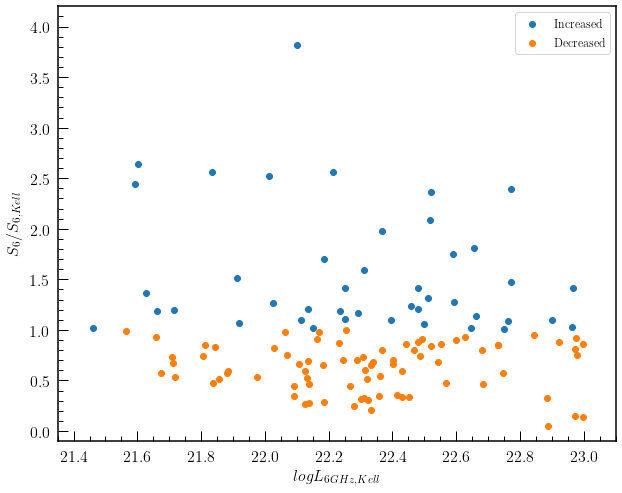

In [9]:
pos = (flux_ratio>1)

fig = plt.figure(figsize=(10,8))

plt.scatter(L6_kell[pos], flux_ratio[pos], label="Increased")
plt.scatter(L6_kell[~pos], flux_ratio[~pos], label="Decreased")



#plt.yscale("log")
#plt.xscale("log")
plt.ylim(-0.1,4.2)
plt.xlim(21.35,23.1)



plt.ylabel("$S_6/S_{6,Kell}$")
plt.xlabel("$logL_{6GHz,Kell}$")
plt.legend(loc="best")
plt.show()

There doesn't appear to be any relation between variability and luminosity - regardless of the sample selection in Barvainis+05, this is consistent with their findings




----

On 8/5/2020, I want to do the same sort of analysis as above, but seeing where the claimed RQQs observed with VLBA in Ulvestad et al. (2005) lie in the same luminosity distribution as above.  Specifically, I'm interested in which sources show a loss of flux density between their respective VLA-->VLBA observations

In [10]:
df4 = pd.read_csv("UlvestadRQQs.csv")

Unames = df4[["Name"]].values.flatten()
alpha_U = df4[["alpha"]].values.flatten()      #spectral indices measured in Ulvestad+05
z_U = df4[["z"]].values.flatten()              
S_U = df4[["S_5GHz [mJy]"]].values.flatten()*1e3 #5GHz flux measured (mJy)
L_U = radluminosity(6., 5., S_U, alpha_U, z_U)

df4["L6GHz [W/Hz; no evolution]"] = L_U
df4["L6GHz [W/Hz; evolution]"] = np.log10((10**L_U) * ((1+0.25)/(1+z_U))**3)
df4.to_csv("UlvestadRQQs.csv", index=False)

df4

,Name,z,S_5GHz [mJy],alpha,L6GHz [W/Hz; no evolution],L6GHz [W/Hz; evolution]
0,J0804+6459,0.148,11.7,-1.1,23.758725,23.869629
1,J1219+0638,0.334,9.1,0.5,24.379118,24.294381
2,J1353+6345,0.087,7.0,-1.5,23.019921,23.201962
3,J1436+5847,0.033,5.1,-1.0,22.028546,22.276976
4,J0046+0104,2.137,4.1,0.0,25.647509,24.448696
5,J1225+2235,2.058,7.3,0.0,25.869145,24.703563
6,J1316+0051,2.393,4.0,0.1,25.677307,24.376285
7,J1409+2618,0.945,5.1,-1.0,25.285767,24.709738


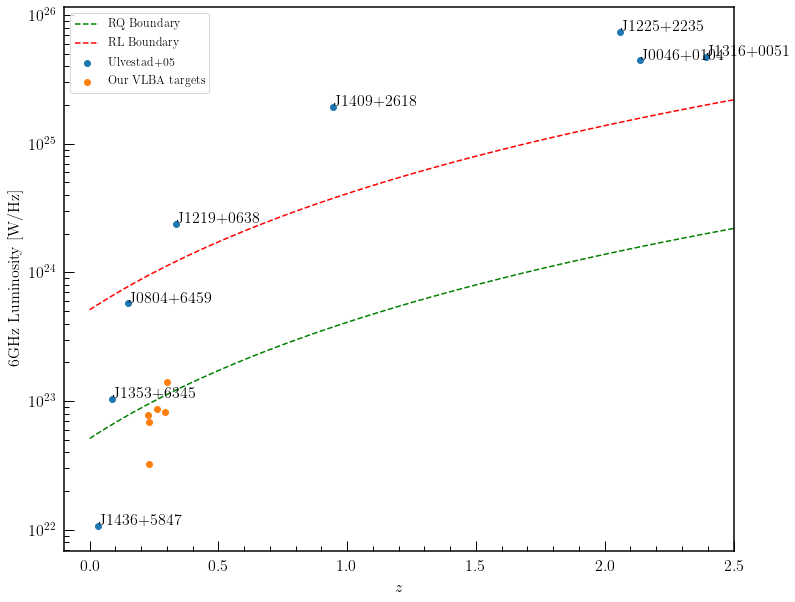

In [11]:
fig = plt.figure(figsize=(12,10))

plt.scatter(z_U, 10**L_U, label="Ulvestad+05")
plt.scatter(z[vlba], 10**L6[vlba], label="Our VLBA targets")
plt.plot(zplot, radio_quiet, '--g', label="RQ Boundary")
plt.plot(zplot, radio_loud, '--r', label="RL Boundary")


for name,redshift,L in zip(Unames,z_U,L_U):                                       
    plt.annotate('%s' % name, xy=(redshift, 10**L), textcoords='data')


plt.xlim(-.1, 2.5)
plt.yscale("log")
plt.ylabel("6GHz Luminosity [W/Hz]")
plt.xlabel("$z$")
plt.legend(loc="best")

----

8/6/2020: Herrera Ruiz et al. (2016) detected 3/18 observed RQQs using the VLBA, arguing that detections of compact radio cores showed that AGN dominates the radio, at least in some RQQs.  They used several criteria to distinguish RQ/RL, but didn't account for any redshift evolution or apply any K-corrections to their 1.4GHz data, so I want to see how introducing some of that compares them to our VLBA targets (and if they're really RQ)

In [12]:
df5 = pd.read_csv("HerreraRuiz2016RQQs.csv")

HRnames = df5[["Name"]].values.flatten()
z_HR = df5[["z"]].values.flatten()              
S_HR = df5[["S_1.4GHz [VLA; uJy]"]].values.flatten() 
L_HR = radluminosity(6., 1.4, S_HR, -0.7, z_HR)

df5["L6GHz [W/Hz; no evolution]"] = L_HR
df5["L6GHz [W/Hz; evolution]"] = np.log10((10**L_HR) * ((1+0.25)/(1+z_HR))**3)
df5.to_csv("HerreraRuiz2016RQQs.csv", index=False)

df5

,Name,z,S_1.4GHz [VLA; uJy],S_1.4GHz [VLBA; uJy],logL_1.4GHz [theirs; W/Hz],L6GHz [W/Hz; no evolution],L6GHz [W/Hz; evolution]
0,C0366,2.94,362,255,25.30,24.804967,23.309208
1,C1397,2.54,293,156,25.07,24.573580,23.217300
2,C1897,1.24,311,236,24.38,23.894526,23.134512


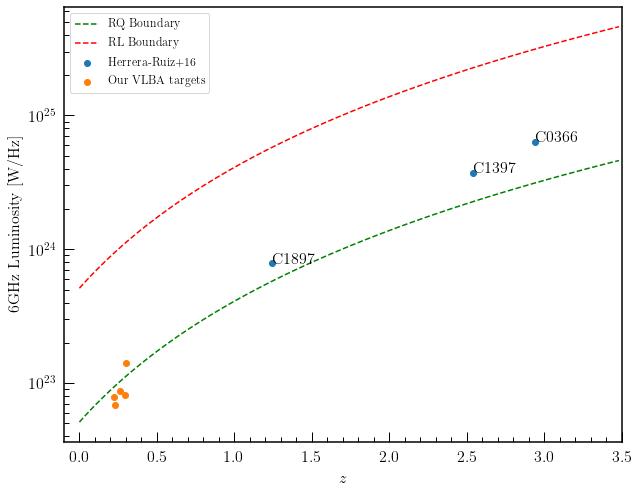

In [13]:
fig = plt.figure(figsize=(10,8))

plt.scatter(z_HR, 10**L_HR, label="Herrera-Ruiz+16")
plt.scatter(z[vlba], 10**L6[vlba], label="Our VLBA targets")
plt.plot(zplot, radio_quiet, '--g', label="RQ Boundary")
plt.plot(zplot, radio_loud, '--r', label="RL Boundary")


for name,redshift,L in zip(HRnames,z_HR,L_HR):                                       
    plt.annotate('%s' % name, xy=(redshift, 10**L), textcoords='data')

plt.xlim(-.1, 3.5)
plt.yscale("log")
plt.ylabel("6GHz Luminosity [W/Hz]")
plt.xlabel("$z$")
plt.legend(loc="best")

In [14]:
bar1 = df3[["L6GHz [W/Hz; evolution]"]].values.flatten()
bar2 = df3[["L6GHz [W/Hz; no evolution]"]].values.flatten()

ulv1 = df4[["L6GHz [W/Hz; evolution]"]].values.flatten()
ulv2 = df4[["L6GHz [W/Hz; no evolution]"]].values.flatten()

HR1 = df5[["L6GHz [W/Hz; evolution]"]].values.flatten()
HR2 = df5[["L6GHz [W/Hz; no evolution]"]].values.flatten()

L6_lin = L6

logbins1 = np.linspace(min(min(L6_lin), min(bar1), min(ulv1)), max(max(L6_lin), max(bar1), max(ulv1)), 20)
logbins2 = np.linspace(min(min(L6_lin), min(bar2), min(ulv2)), max(max(L6_lin), max(bar2), max(ulv2)), 20)

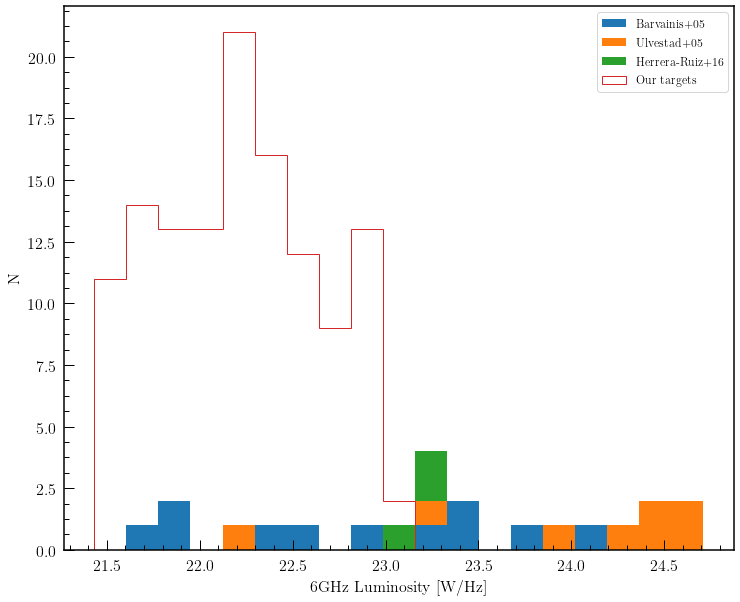

In [15]:
fig = plt.figure(figsize=(12,10))

plt.hist([bar1, ulv1, HR1], histtype="barstacked", bins=logbins1, #density=True,
          label=["Barvainis+05", "Ulvestad+05", "Herrera-Ruiz+16"])
plt.hist(L6_lin, histtype="step", bins=logbins1, #density=True,
          label="Our targets")

plt.xlabel("6GHz Luminosity [W/Hz]")
plt.ylabel("N")
plt.legend(loc="best")



---

## Morphologies

In [16]:
A_morph = df[["A_morph"]].values.flatten()
U = (A_morph=="U")   #unresolved
SR = (A_morph=="SR") #slightly resolved
CL = (A_morph=="CL") #core-lobe
M = (A_morph=="M")   #muliple (>2) component
D = (A_morph=="D")   #double lobe, no core
A = (A_morph=="A")   #asymmetric (basically all the more complicated ones for now)
Qp = (A_morph=="Qp") #"quasi"-point
ND = (A_morph=="ND") #non-detection

In [17]:
print("Morphology number counts for all RQQs\n")

print("Unresolved        : %d" % U.sum())
print("Resolved          : %d\n" % (~U).sum())
print("Slightly resolved : %d" % SR.sum())
print("Core-lobe         : %d" % CL.sum())
print("Multi-component   : %d" % M.sum())
print("Double lobe       : %d" % D.sum())
print("Asymmetric        : %d" % A.sum())
print("Quasi-point       : %d" % Qp.sum())
print("Non-detections    : %d" % ND.sum())

Morphology number counts for all RQQs

Unresolved        : 54
Resolved          : 70

Slightly resolved : 30
Core-lobe         : 9
Multi-component   : 4
Double lobe       : 1
Asymmetric        : 8
Quasi-point       : 2
Non-detections    : 6


In [18]:
Sbins = np.logspace(np.log10(min(S6)), np.log10(max(S6)), 15)
Lbins = np.linspace(min(L6), max(L6), 15)
zbins = np.linspace(min(z), max(z), 15)

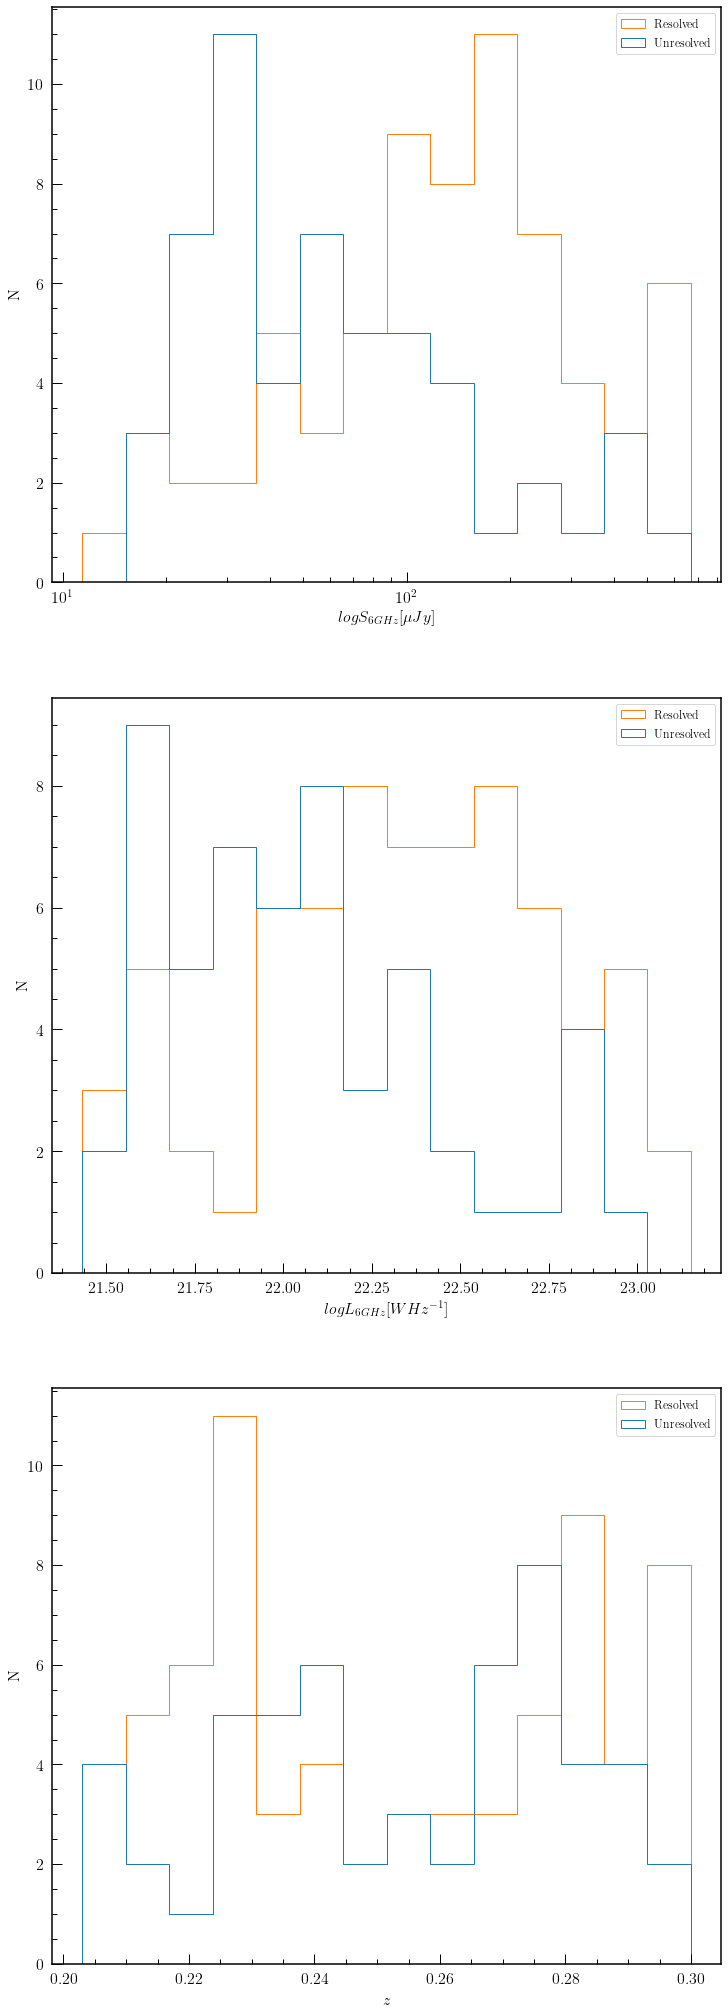

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(12, 36))

axs[0].hist([S6[U], S6[~U]], histtype="step", bins=Sbins, label=["Unresolved", "Resolved"])

axs[0].set_xscale("log")
axs[0].set_xlabel("$log S_{6GHz} [\mu Jy]$")
axs[0].set_ylabel("N")
axs[0].legend(loc="best")


axs[1].hist([L6[U], L6[~U]], histtype="step", bins=Lbins, label=["Unresolved", "Resolved"])

axs[1].set_xlabel("$log L_{6GHz} [W Hz^{-1}]$")
axs[1].set_ylabel("N")
axs[1].legend(loc="best")


axs[2].hist([z[U], z[~U]], histtype="step", bins=zbins, label=["Unresolved", "Resolved"])

axs[2].set_xlabel("$z$")
axs[2].set_ylabel("N")
axs[2].legend(loc="best")

A not overly surprising result: resolved sources tend to have higher flux densities than the unresolved sources - though is the difference subtler in the luminosity plot?  There doesn't seem to been any significant skew in the redshift plot (definitely not as strong as the separation in flux densities.


###### How does the flux ratio correlate with morphology?

Unresolved sources
Median ratio: 0.74
Mean ratio  : 0.83
Std ratio   : 0.47


Resolved sources
Median ratio: 0.91
Mean ratio  : 1.20
Std ratio   : 1.35


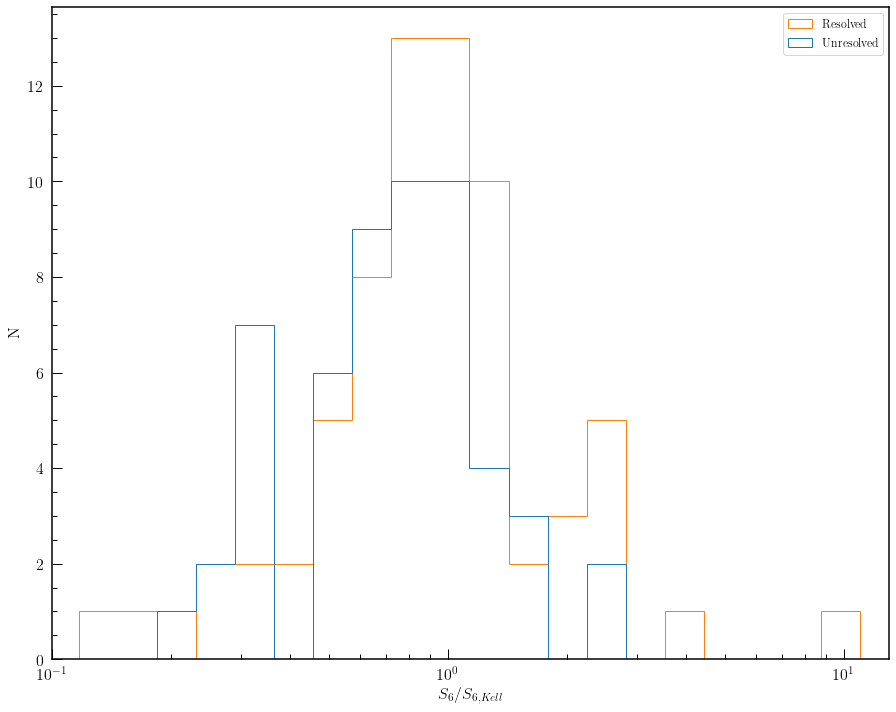

In [20]:
fig = plt.figure(figsize=(15,12))

plt.hist([flux_ratio[U], flux_ratio[~U]], histtype="step", bins=bins4, label=["Unresolved", "Resolved"])

plt.xscale("log")
plt.xlim(1e-1, 1.3e1)
plt.xlabel("$S_6/S_{6,Kell}$")
plt.ylabel("N")
plt.legend(loc="best")

print("Unresolved sources")
print("Median ratio: %.2f" % (np.median(flux_ratio[U])))
print("Mean ratio  : %.2f" % (np.mean(flux_ratio[U])))
print("Std ratio   : %.2f\n\n" % (np.std(flux_ratio[U])))

print("Resolved sources")
print("Median ratio: %.2f" % (np.median(flux_ratio[~U])))
print("Mean ratio  : %.2f" % (np.mean(flux_ratio[~U])))
print("Std ratio   : %.2f" % (np.std(flux_ratio[~U])))

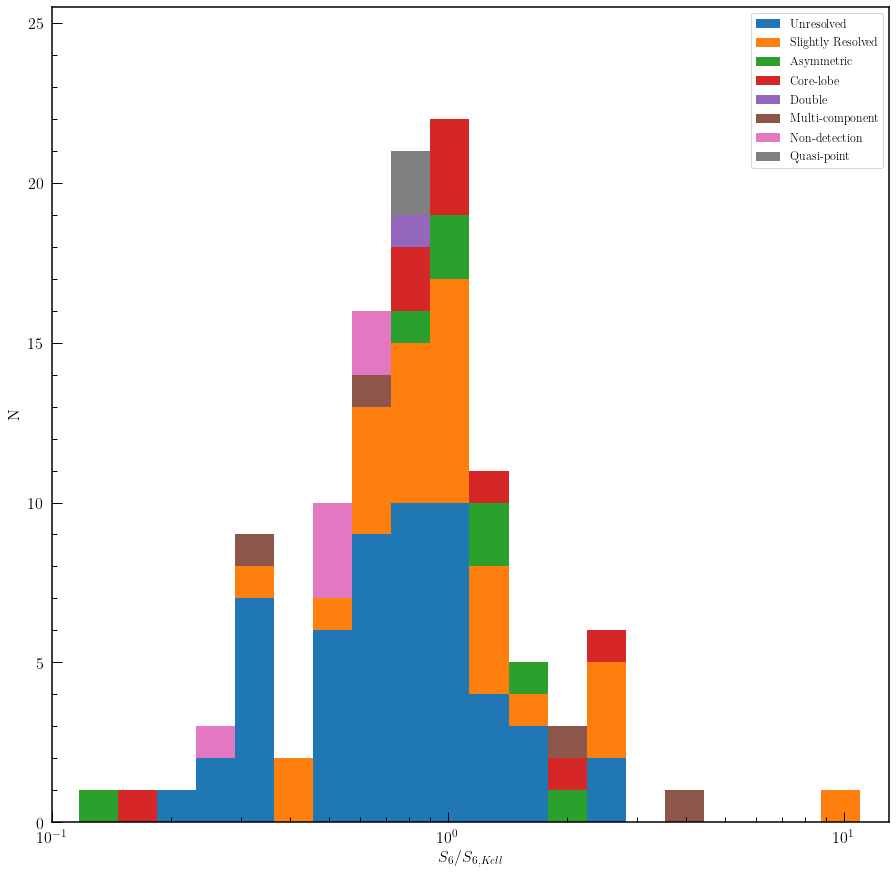

In [21]:
fig = plt.figure(figsize=(15,15))

plt.hist([flux_ratio[U], flux_ratio[SR], flux_ratio[A], flux_ratio[CL], flux_ratio[D]
         , flux_ratio[M], flux_ratio[ND], flux_ratio[Qp]], histtype="barstacked", bins=bins4, 
         label=["Unresolved", "Slightly Resolved", "Asymmetric", "Core-lobe", "Double", 
                "Multi-component", "Non-detection", "Quasi-point"])

plt.xlabel("$S_6/S_{6,Kell}$")
plt.ylabel("N")
plt.xlim(1e-1, 1.3e1)
plt.ylim(0,25.5)
plt.xscale("log")
plt.legend(loc="best")
plt.show()